# Imports

In [2]:
%matplotlib inline 

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from astropy.table import Table
from scipy.optimize import curve_fit
from functools import reduce

import model_flux_ratio as mfr
import pca

In [3]:
path = os.getcwd()

# PCA for emissivities


The Storey & Sochi 2015 hydrogen emissivities only go down to a density of n_e=100. We are using a PCA to extrapolate down to lower densities

In [139]:
hydrogen_emis_noextrap = Table.read(path+'/tables/hydrogen_emissivity_noextrap', format='ascii', delimiter='\t')

## Functional form for the fit to emissivities

In [140]:
def functional_form(T, a, b, c, d):
    #emis = ( a - (b * np.log(T)**2) + (c * np.log(T)) + (d / np.log(T)) ) * T**-1
    
    # Need to use a polynomial (instead of our original modified polynomial above) to match
    # the polynomial fit that is going on in PCA
    emis = ( a + (b * np.log10(T)) + (c * np.log10(T)**2) + (d * np.log10(T)**3) )

    return emis

## Temperature and density range for fit

Fitting only the temperature range ~5000-25000 K, for (1) a better fit in (2) the range we really care about

In [141]:
# New temperature array
temps = 10**np.linspace(3.7, 4.4, num=8) #np.linspace(5e3, 25e3, num=21)
print (temps)

[ 5011.87233627  6309.5734448   7943.28234724 10000.
 12589.25411794 15848.93192461 19952.62314969 25118.8643151 ]


These densities correspond to those given as data points from the Storey & Sochi 2015 hydrogen emissivities

In [142]:
ne_array = 10**np.array([2,3,4,5,6])

print (ne_array, len(ne_array))

[    100    1000   10000  100000 1000000] 5


## Fit and show results!

In [143]:
# Empty arrays to save the coefficients of our functional form from scipy's curve_fit
# Our functional form has 4 coefficients: a, b, c, d and we will have one at each density value
# (i.e., at n_e = 100, there will be a, b, c, d; at n_e = 1000, there will be a, b, c, d)
ha_a_coeff = np.zeros(len(ne_array))
ha_b_coeff = np.zeros(len(ne_array))
ha_c_coeff = np.zeros(len(ne_array))
ha_d_coeff = np.zeros(len(ne_array))

hb_a_coeff = np.zeros(len(ne_array))
hb_b_coeff = np.zeros(len(ne_array))
hb_c_coeff = np.zeros(len(ne_array))
hb_d_coeff = np.zeros(len(ne_array))

hg_a_coeff = np.zeros(len(ne_array))
hg_b_coeff = np.zeros(len(ne_array))
hg_c_coeff = np.zeros(len(ne_array))
hg_d_coeff = np.zeros(len(ne_array))

hd_a_coeff = np.zeros(len(ne_array))
hd_b_coeff = np.zeros(len(ne_array))
hd_c_coeff = np.zeros(len(ne_array))
hd_d_coeff = np.zeros(len(ne_array))

h8_a_coeff = np.zeros(len(ne_array))
h8_b_coeff = np.zeros(len(ne_array))
h8_c_coeff = np.zeros(len(ne_array))
h8_d_coeff = np.zeros(len(ne_array))

pg_a_coeff = np.zeros(len(ne_array))
pg_b_coeff = np.zeros(len(ne_array))
pg_c_coeff = np.zeros(len(ne_array))
pg_d_coeff = np.zeros(len(ne_array))

In [144]:
# Open .pdf to save emissivity and residual plots in
ha_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/halpha_curvefits_residuals.pdf')
hg_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/hgamma_curvefits_residuals.pdf')
hd_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/hdelta_curvefits_residuals.pdf')
h8_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/h8_curvefits_residuals.pdf')
pg_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/pg_curvefits_residuals.pdf')

# Loop through density values for which we have data
for dens in range(len(ne_array)):
    # Find indices in hydrogen_emissivity_noextrap that correspond to Balmer transitions of interest
    # and pull the emissivity values at those indices
    ss2015_ha = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[dens]))))]
    ss2015_hb = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[dens]))))]
    ss2015_hg = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 5)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[dens]))))]
    ss2015_hd = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 6)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[dens]))))]
    ss2015_h8 = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 8)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[dens]))))]
    ss2015_pg = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 6)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 3)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[dens]))))]

    # Fit a functional form to our new extrapolated emissivities
    popta, pcova = curve_fit(functional_form, temps, ss2015_ha)
    ha_a_coeff[dens] = popta[0]
    ha_b_coeff[dens] = popta[1]
    ha_c_coeff[dens] = popta[2]
    ha_d_coeff[dens] = popta[3]
     
    poptb, pcovb = curve_fit(functional_form, temps, ss2015_hb)
    hb_a_coeff[dens] = poptb[0]
    hb_b_coeff[dens] = poptb[1]
    hb_c_coeff[dens] = poptb[2]
    hb_d_coeff[dens] = poptb[3]
    
    poptg, pcovg = curve_fit(functional_form, temps, ss2015_hg)
    hg_a_coeff[dens] = poptg[0]
    hg_b_coeff[dens] = poptg[1]
    hg_c_coeff[dens] = poptg[2]
    hg_d_coeff[dens] = poptg[3]
    
    poptd, pcovd = curve_fit(functional_form, temps, ss2015_hd)
    hd_a_coeff[dens] = poptd[0]
    hd_b_coeff[dens] = poptd[1]
    hd_c_coeff[dens] = poptd[2]
    hd_d_coeff[dens] = poptd[3]
    
    popt8, pcov8 = curve_fit(functional_form, temps, ss2015_h8)
    h8_a_coeff[dens] = popt8[0]
    h8_b_coeff[dens] = popt8[1]
    h8_c_coeff[dens] = popt8[2]
    h8_d_coeff[dens] = popt8[3]
    
    poptpg, pcovpg = curve_fit(functional_form, temps, ss2015_pg)
    pg_a_coeff[dens] = poptpg[0]
    pg_b_coeff[dens] = poptpg[1]
    pg_c_coeff[dens] = poptpg[2]
    pg_d_coeff[dens] = poptpg[3]
'''   
    # Calculate the old H&S 1987 emissivities at this density for comparison
    old_ha_dens = mfr.hydrogen_emissivity_old(6563, temps, ne_array[dens]) * (1 + mfr.hydrogen_collision_to_recomb(1e-4, 6563, temps)) / (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4861, temps))
    old_hb_dens = mfr.hydrogen_emissivity_old(4861, temps, ne_array[dens])
    old_hg_dens = mfr.hydrogen_emissivity_old(4341, temps, ne_array[dens]) * (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4341, temps)) / (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4861, temps))
    old_hd_dens = mfr.hydrogen_emissivity_old(4102, temps, ne_array[dens]) * (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4102, temps)) / (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4861, temps))

    # Plot!
    # H-alpha
    ha_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(temps, functional_form(temps, *popta)/functional_form(temps, *poptb), label='scipy curvefit', color='magenta')
    ax1.plot(temps, ss2015_ha/ss2015_hb, label='S\&S 2015', color='blue', marker='^', markersize=10, linestyle='None')
    ax1.plot(temps, old_ha_dens, 'o', label='H-alpha, H\&S 1987', color='red')
    ax1.set_xscale('log')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Emissivity Ratio')
    ax1.set_title(r'E(H$\alpha$)/E(H$\beta), n_{e}=$'+str(ne_array[dens]))
    ax1.legend()
    ax2.plot(temps, ((functional_form(temps, *popta)/functional_form(temps, *poptb)-(ss2015_ha/ss2015_hb))/(ss2015_ha/ss2015_hb)), label='scipy curvefit', color='magenta')
    ax2.axhline(0.001, ls='--', color='black')
    ax2.axhline(-0.001, ls='--', color='black')
    ax2.set_xscale('log')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel(r'Residuals')
    ax2.set_title(r'$n_{e}$='+str(ne_array[dens])+'~$cm^{-3}$')
    ha_pdf.savefig(ha_f)
    
    # H-gamma
    hg_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(temps, functional_form(temps, *poptg)/functional_form(temps, *poptb), label='scipy curvefit', color='magenta')
    ax1.plot(temps, ss2015_hg/ss2015_hb, label='S\&S 2015', color='blue', marker='^', markersize=10, linestyle='None')
    ax1.plot(temps, old_hg_dens, 'o', label='H-alpha, H\&S 1987', color='red')
    ax1.set_xscale('log')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Emissivity Ratio')
    ax1.set_title(r'E(H$\gamma$)/E(H$\beta), n_{e}=$'+str(ne_array[dens]))
    ax1.legend()
    ax2.plot(temps, ((functional_form(temps, *poptg)/functional_form(temps, *poptb)-(ss2015_hg/ss2015_hb))/(ss2015_hg/ss2015_hb)), label='scipy curvefit', color='magenta')
    ax2.axhline(0.001, ls='--', color='black')
    ax2.axhline(-0.001, ls='--', color='black')
    ax2.set_xscale('log')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel(r'Residuals')
    ax2.set_title(r'$n_{e}$='+str(ne_array[dens])+'~$cm^{-3}$')
    hg_pdf.savefig(hg_f)
    
    # H-delta
    hd_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(temps, functional_form(temps, *poptd)/functional_form(temps, *poptb), label='scipy curvefit', color='magenta')
    ax1.plot(temps, ss2015_hd/ss2015_hb, label='S\&S 2015', color='blue', marker='^', markersize=10, linestyle='None')
    ax1.plot(temps, old_hd_dens, 'o', label='H-alpha, H\&S 1987', color='red')
    ax1.set_xscale('log')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Emissivity Ratio')
    ax1.set_title(r'E(H$\delta$)/E(H$\beta), n_{e}=$'+str(ne_array[dens]))
    ax1.legend()
    ax2.plot(temps, ((functional_form(temps, *poptd)/functional_form(temps, *poptb)-(ss2015_hd/ss2015_hb))/(ss2015_hd/ss2015_hb)), label='scipy curvefit', color='magenta')
    ax2.axhline(0.001, ls='--', color='black')
    ax2.axhline(-0.001, ls='--', color='black')
    ax2.set_xscale('log')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel(r'Residuals')
    ax2.set_title(r'$n_{e}$='+str(ne_array[dens])+'~$cm^{-3}$')
    hd_pdf.savefig(hd_f)
    
    # H8
    h8_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(temps, functional_form(temps, *popt8)/functional_form(temps, *poptb), label='scipy curvefit', color='magenta')
    ax1.plot(temps, ss2015_h8/ss2015_hb, label='S\&S 2015', color='blue', marker='^', markersize=10, linestyle='None')
    ax1.set_xscale('log')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Emissivity Ratio')
    ax1.set_title(r'E(H8)/E(H$\beta), n_{e}=$'+str(ne_array[dens]))
    ax1.legend()
    ax2.plot(temps, ((functional_form(temps, *popt8)/functional_form(temps, *poptb)-(ss2015_h8/ss2015_hb))/(ss2015_h8/ss2015_hb)), label='scipy curvefit', color='magenta')
    ax2.axhline(0.001, ls='--', color='black')
    ax2.axhline(-0.001, ls='--', color='black')
    ax2.set_xscale('log')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel(r'Residuals')
    ax2.set_title(r'$n_{e}$='+str(ne_array[dens])+'~$cm^{-3}$')
    h8_pdf.savefig(h8_f)
    
    # Pa-gamma
    pg_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(temps, functional_form(temps, *poptpg)/functional_form(temps, *poptb), label='scipy curvefit', color='magenta')
    ax1.plot(temps, ss2015_pg/ss2015_hb, label='S\&S 2015', color='blue', marker='^', markersize=10, linestyle='None')
    ax1.set_xscale('log')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Emissivity Ratio')
    ax1.set_title(r'E(Pa$\gamma$)/E(H$\beta), n_{e}=$'+str(ne_array[dens]))
    ax1.legend()
    ax2.plot(temps, ((functional_form(temps, *poptpg)/functional_form(temps, *poptb)-(ss2015_pg/ss2015_hb))/(ss2015_pg/ss2015_hb)), label='scipy curvefit', color='magenta')
    ax2.axhline(0.001, ls='--', color='black')
    ax2.axhline(-0.001, ls='--', color='black')
    ax2.set_xscale('log')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel(r'Residuals')
    ax2.set_title(r'$n_{e}$='+str(ne_array[dens])+'~$cm^{-3}$')
    pg_pdf.savefig(pg_f)
        
# Close pdfs
ha_pdf.close()
hg_pdf.close()
hd_pdf.close()
h8_pdf.close()
pg_pdf.close()
# Show whichever plot we want
#hd_f.show()
''' 

"   \n    # Calculate the old H&S 1987 emissivities at this density for comparison\n    old_ha_dens = mfr.hydrogen_emissivity_old(6563, temps, ne_array[dens]) * (1 + mfr.hydrogen_collision_to_recomb(1e-4, 6563, temps)) / (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4861, temps))\n    old_hb_dens = mfr.hydrogen_emissivity_old(4861, temps, ne_array[dens])\n    old_hg_dens = mfr.hydrogen_emissivity_old(4341, temps, ne_array[dens]) * (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4341, temps)) / (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4861, temps))\n    old_hd_dens = mfr.hydrogen_emissivity_old(4102, temps, ne_array[dens]) * (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4102, temps)) / (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4861, temps))\n\n    # Plot!\n    # H-alpha\n    ha_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))\n    ax1.plot(temps, functional_form(temps, *popta)/functional_form(temps, *poptb), label='scipy curvefit', color='magenta')\n    ax1.plot(temps, ss2015_ha/ss2015_

# Attempt PCA

## Reload modules

In [12]:
import importlib
importlib.reload(pca)
importlib.reload(mfr)

<module 'model_flux_ratio' from '/Users/thsyu/Software/Yp/model_flux_ratio.py'>

This is PypeIt's call to pca.basis and what each variable passed in means, for reference

## PCA input parameters

In [13]:
temps_arr = np.log10(np.repeat(temps, ne_array.size)).reshape(8,5) #np.log10(np.tile(temps, (5, 1)))
# Need emis_arr to be emissivities at these temperatures and at the different densities..!\

ha_emis_at_td = np.zeros((5,8))
hb_emis_at_td = np.zeros((5,8))
hg_emis_at_td = np.zeros((5,8))
hd_emis_at_td = np.zeros((5,8))
h8_emis_at_td = np.zeros((5,8))
pg_emis_at_td = np.zeros((5,8))

for i in range(ne_array.size):
    ha_emis_at_td[i] = functional_form(temps, ha_a_coeff[i], ha_b_coeff[i], ha_c_coeff[i], ha_d_coeff[i])
    hb_emis_at_td[i] = functional_form(temps, hb_a_coeff[i], hb_b_coeff[i], hb_c_coeff[i], hb_d_coeff[i])
    hg_emis_at_td[i] = functional_form(temps, hg_a_coeff[i], hg_b_coeff[i], hg_c_coeff[i], hg_d_coeff[i])
    hd_emis_at_td[i] = functional_form(temps, hd_a_coeff[i], hd_b_coeff[i], hd_c_coeff[i], hd_d_coeff[i])
    h8_emis_at_td[i] = functional_form(temps, h8_a_coeff[i], h8_b_coeff[i], h8_c_coeff[i], h8_d_coeff[i])
    pg_emis_at_td[i] = functional_form(temps, pg_a_coeff[i], pg_b_coeff[i], pg_c_coeff[i], pg_d_coeff[i])

ha_emis_arr = np.dstack((ha_emis_at_td[0], ha_emis_at_td[1], ha_emis_at_td[2], ha_emis_at_td[3], ha_emis_at_td[4]))[0]
hb_emis_arr = np.dstack((hb_emis_at_td[0], hb_emis_at_td[1], hb_emis_at_td[2], hb_emis_at_td[3], hb_emis_at_td[4]))[0]
hg_emis_arr = np.dstack((hg_emis_at_td[0], hg_emis_at_td[1], hg_emis_at_td[2], hg_emis_at_td[3], hg_emis_at_td[4]))[0]
hd_emis_arr = np.dstack((hd_emis_at_td[0], hd_emis_at_td[1], hd_emis_at_td[2], hd_emis_at_td[3], hd_emis_at_td[4]))[0]
h8_emis_arr = np.dstack((h8_emis_at_td[0], h8_emis_at_td[1], h8_emis_at_td[2], h8_emis_at_td[3], h8_emis_at_td[4]))[0]
pg_emis_arr = np.dstack((pg_emis_at_td[0], pg_emis_at_td[1], pg_emis_at_td[2], pg_emis_at_td[3], pg_emis_at_td[4]))[0]

ha_coeffs = np.stack((ha_a_coeff, ha_b_coeff, ha_c_coeff, ha_d_coeff))
hb_coeffs = np.stack((hb_a_coeff, hb_b_coeff, hb_c_coeff, hb_d_coeff))
hg_coeffs = np.stack((hg_a_coeff, hg_b_coeff, hg_c_coeff, hg_d_coeff))
hd_coeffs = np.stack((hd_a_coeff, hd_b_coeff, hd_c_coeff, hd_d_coeff))
h8_coeffs = np.stack((h8_a_coeff, h8_b_coeff, h8_c_coeff, h8_d_coeff))
pg_coeffs = np.stack((pg_a_coeff, pg_b_coeff, pg_c_coeff, pg_d_coeff))

ofit = np.array([1,1,1,1])
lnpc = len(ofit) - 1
dens_arr = np.log10(ne_array)

## Run PCA

In [14]:
ha_fitted, ha_outpar = pca.basis(temps_arr, ha_emis_arr, ha_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
hb_fitted, hb_outpar = pca.basis(temps_arr, hb_emis_arr, hb_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
hg_fitted, hg_outpar = pca.basis(temps_arr, hg_emis_arr, hg_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
hd_fitted, hd_outpar = pca.basis(temps_arr, hd_emis_arr, hd_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
h8_fitted, h8_outpar = pca.basis(temps_arr, h8_emis_arr, h8_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
pg_fitted, pg_outpar = pca.basis(temps_arr, pg_emis_arr, pg_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)


Reduced chi-squared = 7.559376E-07
Reduced chi-squared = 7.693935E-06
Reduced chi-squared = 3.572147E-06
Reduced chi-squared = 2.291384E-06
Reduced chi-squared = 2.976358E-06
Reduced chi-squared = 8.684406E-11


## Extrapolation

### Grid of densities for extrapolation

In [15]:
extrap_ne_array = np.array([0,1,2,3,4,5,6]) #np.linspace(0, 6, 100)

In [16]:
ha_extfit, ha_outpar2 = pca.extrapolate(ha_outpar, extrap_ne_array)
hb_extfit, hb_outpar2 = pca.extrapolate(hb_outpar, extrap_ne_array)
hg_extfit, hg_outpar2 = pca.extrapolate(hg_outpar, extrap_ne_array)
hd_extfit, hd_outpar2 = pca.extrapolate(hd_outpar, extrap_ne_array)
h8_extfit, h8_outpar2 = pca.extrapolate(h8_outpar, extrap_ne_array)
pg_extfit, pg_outpar2 = pca.extrapolate(pg_outpar, extrap_ne_array)

In [18]:
pca.pca_plot(ha_outpar, ofit, 'pca_1111_ha')
pca.pca_plot(hb_outpar, ofit, 'pca_1111_hb')
pca.pca_plot(hg_outpar, ofit, 'pca_1111_hg')
pca.pca_plot(hd_outpar, ofit, 'pca_1111_hd')
pca.pca_plot(h8_outpar, ofit, 'pca_1111_h8')
pca.pca_plot(pg_outpar, ofit, 'pca_1111_pg')

<Figure size 640x480 with 0 Axes>

# Compare all hydrogen emissivities!

Includes:

SS2015

NEBULAR, which uses SS2015 and extrapolates to log(ne)=0,1

PCA, where we use SS2015 and extrapolate to log(ne)=0,1

S2018, no extrapolation (i.e., where Peter Storey kindly calculated emissivities down to log(ne)=0,1!)

In [101]:
# Import Storey's 2018 calculations, SS2015
hydrogen_emis_2018 = Table.read('/Users/thsyu/Software/Yp/tables/r1B/hydrogen_emissivity_storey2018', format='ascii', delimiter=' ')
hydrogen_emis_short = Table.read('/Users/thsyu/Software/Yp/tables/hydrogen_emissivity_short', format='ascii', delimiter='\t')


In [54]:
color = cm.jet(np.linspace(0,1,7))

## SS2015, no values past log(ne)=0,1

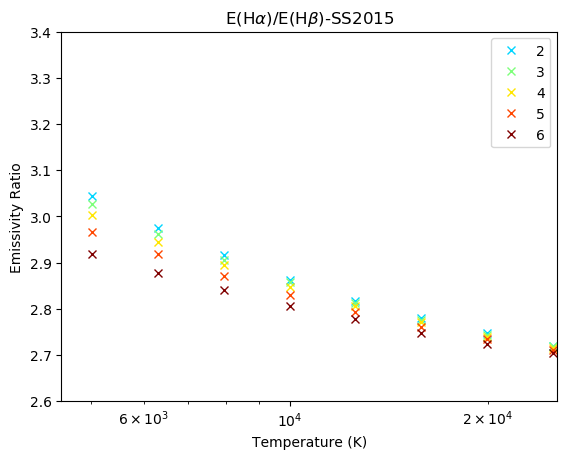

In [129]:
plt.plot(10**hydrogen_emis_noextrap['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 2)))], hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 2))]/hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 2))], marker='x', linestyle='None', color=color[2], label='2')
plt.plot(10**hydrogen_emis_noextrap['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 3)))], hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 3))]/hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 3))], marker='x', linestyle='None', color=color[3], label='3')
plt.plot(10**hydrogen_emis_noextrap['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 4)))], hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 4))]/hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 4))], marker='x', linestyle='None', color=color[4], label='4')
plt.plot(10**hydrogen_emis_noextrap['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 5)))], hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 5))]/hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 5))], marker='x', linestyle='None', color=color[5], label='5')
plt.plot(10**hydrogen_emis_noextrap['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 6)))], hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 6))]/hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 6))], marker='x', linestyle='None', color=color[6], label='6')

plt.xlabel('Temperature (K)')
plt.ylabel('Emissivity Ratio')
plt.title(r'E(H$\alpha$)/E(H$\beta$)-SS2015')
plt.xlim(4500, 25500)
plt.ylim(2.6, 3.4)
plt.xscale('log')
plt.legend()
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/SS2015_Trange.pdf', overwrite=True)
plt.show()

## NEBULAR, which is SS2015 extrapolated down to log(ne)=0,1

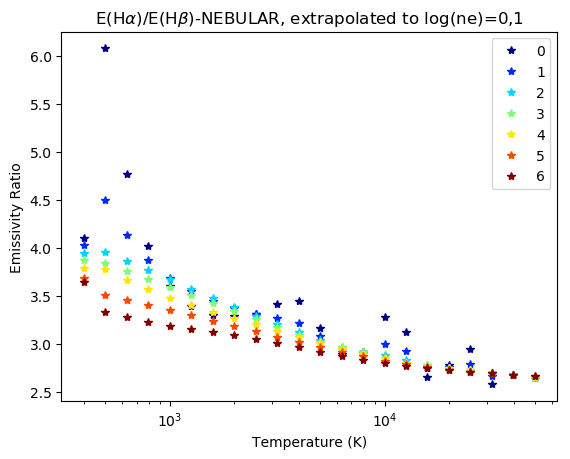

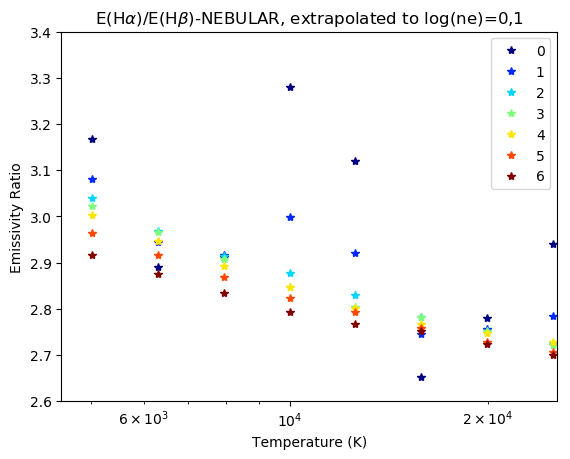

In [105]:
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 0)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 0))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 0))], marker='*', linestyle='None', color=color[0], label='0')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 1)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 1))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 1))], marker='*', linestyle='None', color=color[1], label='1')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 2)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 2))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 2))], marker='*', linestyle='None', color=color[2], label='2')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 3)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 3))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 3))], marker='*', linestyle='None', color=color[3], label='3')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 4)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 4))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 4))], marker='*', linestyle='None', color=color[4], label='4')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 5)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 5))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 5))], marker='*', linestyle='None', color=color[5], label='5')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 6)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 6))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 6))], marker='*', linestyle='None', color=color[6], label='6')

plt.xlabel('Temperature (K)')
plt.ylabel('Emissivity Ratio')
plt.title(r'E(H$\alpha$)/E(H$\beta$)-NEBULAR, extrapolated to log(ne)=0,1')
#plt.xlim(4500, 25500)
plt.xscale('log')
plt.legend()
plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/nebular_extrap_allT.pdf', overwrite=True)
plt.show()

plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 0)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 0))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 0))], marker='*', linestyle='None', color=color[0], label='0')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 1)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 1))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 1))], marker='*', linestyle='None', color=color[1], label='1')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 2)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 2))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 2))], marker='*', linestyle='None', color=color[2], label='2')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 3)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 3))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 3))], marker='*', linestyle='None', color=color[3], label='3')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 4)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 4))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 4))], marker='*', linestyle='None', color=color[4], label='4')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 5)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 5))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 5))], marker='*', linestyle='None', color=color[5], label='5')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 6)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 6))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 6))], marker='*', linestyle='None', color=color[6], label='6')

plt.xlabel('Temperature (K)')
plt.ylabel('Emissivity Ratio')
plt.title(r'E(H$\alpha$)/E(H$\beta$)-NEBULAR, extrapolated to log(ne)=0,1')
plt.xlim(4500, 25500)
plt.ylim(2.6, 3.4)
plt.xscale('log')
plt.legend()
plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/nebular_extrap_Trange.pdf', overwrite=True)
plt.show()

## Storey 2018

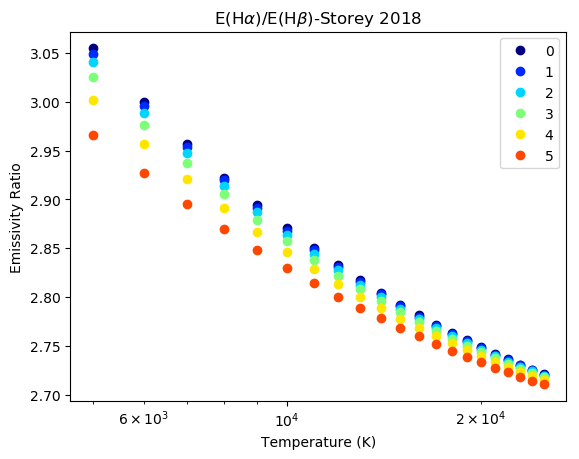

In [106]:
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 0.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 0.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 0.000))], marker='o', linestyle='None', color=color[0], label='0')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 1.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 1.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 1.000))], marker='o', linestyle='None', color=color[1], label='1')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 2.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 2.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 2.000))], marker='o', linestyle='None', color=color[2], label='2')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 3.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 3.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 3.000))], marker='o', linestyle='None', color=color[3], label='3')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 4.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 4.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 4.000))], marker='o', linestyle='None', color=color[4], label='4')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 5.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 5.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 5.000))], marker='o', linestyle='None', color=color[5], label='5')
plt.xlabel('Temperature (K)')
plt.ylabel('Emissivity Ratio')
plt.title(r'E(H$\alpha$)/E(H$\beta$)-Storey 2018')
plt.xscale('log')
plt.legend()
plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/S2018.pdf', overwrite=True)
plt.show()

## S2018 vs NEBULAR

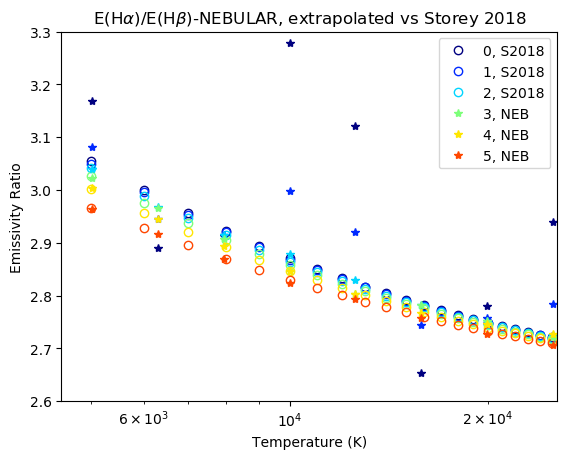

In [113]:
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 0.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 0.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 0.000))], marker='o', linestyle='None', fillstyle='none', color=color[0], label='0, S2018')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 1.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 1.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 1.000))], marker='o', linestyle='None', fillstyle='none', color=color[1], label='1, S2018')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 2.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 2.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 2.000))], marker='o', linestyle='None', fillstyle='none', color=color[2], label='2, S2018')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 3.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 3.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 3.000))], marker='o', linestyle='None', fillstyle='none', color=color[3], label='_nolegend_')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 4.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 4.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 4.000))], marker='o', linestyle='None', fillstyle='none', color=color[4], label='_nolegend_')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 5.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 5.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 5.000))], marker='o', linestyle='None', fillstyle='none', color=color[5], label='_nolegend_')

plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 0)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 0))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 0))], marker='*', linestyle='None', color=color[0], label='_nolegend_')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 1)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 1))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 1))], marker='*', linestyle='None', color=color[1], label='_nolegend_')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 2)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 2))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 2))], marker='*', linestyle='None', color=color[2], label='_nolegend_')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 3)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 3))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 3))], marker='*', linestyle='None', color=color[3], label='3, NEB')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 4)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 4))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 4))], marker='*', linestyle='None', color=color[4], label='4, NEB')
plt.plot(10**hydrogen_emis_short['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_short['log(ne)'] == 5)))], hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 3)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 5))]/hydrogen_emis_short['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_short['Nu'] == 4)[0], np.where(hydrogen_emis_short['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_short['log(ne)'] == 5))], marker='*', linestyle='None', color=color[5], label='5, NEB')

plt.xlabel('Temperature (K)')
plt.ylabel('Emissivity Ratio')
plt.title(r'E(H$\alpha$)/E(H$\beta$)-NEBULAR, extrapolated vs Storey 2018')
plt.xlim(4500, 25500)
plt.ylim(2.6, 3.3)
plt.xscale('log')
plt.legend()
plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/nebular_extrap_vs_S2018.pdf', overwrite=True)
plt.show()

## S2018 vs PCA

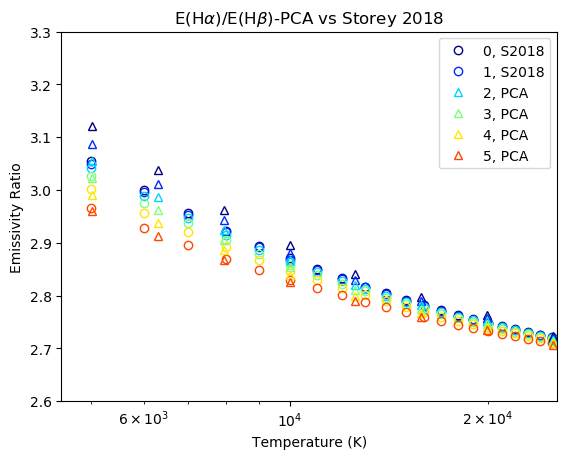

In [132]:
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                    np.where(hydrogen_emis_2018['log(ne)'] == 0.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                    np.where(hydrogen_emis_2018['log(ne)'] == 0.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                    np.where(hydrogen_emis_2018['log(ne)'] == 0.000))], marker='o', linestyle='None', fillstyle='none', color=color[0], label='0, S2018')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 1.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 1.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 1.000))], marker='o', linestyle='None', fillstyle='none', color=color[1], label='1, S2018')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 2.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 2.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 2.000))], marker='o', linestyle='None', fillstyle='none', color=color[2], label='_nolegend_')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 3.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 3.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 3.000))], marker='o', linestyle='None', fillstyle='none', color=color[3], label='_nolegend_')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 4.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 4.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 4.000))], marker='o', linestyle='None', fillstyle='none', color=color[4], label='_nolegend_')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 5.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 5.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 5.000))], marker='o', linestyle='None', fillstyle='none', color=color[5], label='_nolegend_')

for i in range(len(extrap_ne_array)):
    leg_label = str(extrap_ne_array[i]) + ', PCA'
    if i < 2:
        plt.plot(temps, ha_extfit.T[i]/hb_extfit.T[i], label='_nolegend_', marker='^', linestyle='None', fillstyle='none', color=color[i])

    elif i >= 2 and i < 6:
        plt.plot(temps, ha_extfit.T[i]/hb_extfit.T[i], label=leg_label, marker='^', linestyle='None', fillstyle='none', color=color[i])

plt.xlabel('Temperature (K)')
plt.ylabel('Emissivity Ratio')
plt.title(r'E(H$\alpha$)/E(H$\beta$)-PCA vs Storey 2018')
plt.xlim(4500, 25500)
plt.ylim(2.6, 3.3)
plt.xscale('log')
plt.legend()
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/PCA_vs_S2018.pdf', overwrite=True)
plt.show()

## S2018 vs SS2015 (just to check emissivities are the same in overlapping log(ne))

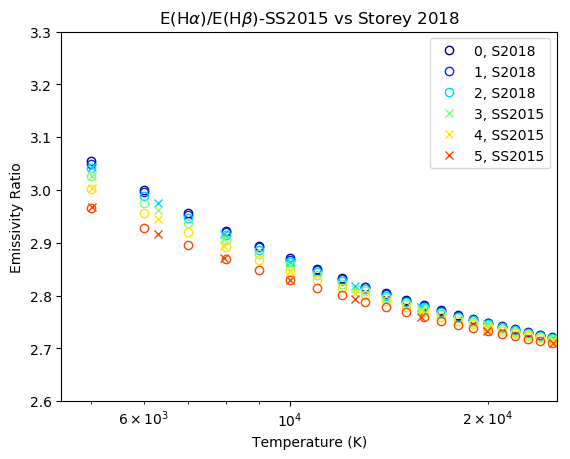

In [137]:
#Storey 2018
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                    np.where(hydrogen_emis_2018['log(ne)'] == 0.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                    np.where(hydrogen_emis_2018['log(ne)'] == 0.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                    np.where(hydrogen_emis_2018['log(ne)'] == 0.000))], marker='o', linestyle='None', fillstyle='none', color=color[0], label='0, S2018')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 1.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 1.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 1.000))], marker='o', linestyle='None', fillstyle='none', color=color[1], label='1, S2018')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 2.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 2.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 2.000))], marker='o', linestyle='None', fillstyle='none', color=color[2], label='2, S2018')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 3.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 3.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 3.000))], marker='o', linestyle='None', fillstyle='none', color=color[3], label='_nolegend_')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 4.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 4.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 4.000))], marker='o', linestyle='None', fillstyle='none', color=color[4], label='_nolegend_')
plt.plot(hydrogen_emis_2018['T'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 5.000))], hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 3)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 5.000))]/hydrogen_emis_2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_2018['Nu'] == 4)[0], np.where(hydrogen_emis_2018['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_2018['log(ne)'] == 5.000))], marker='o', linestyle='None', fillstyle='none', color=color[5], label='_nolegend_')
# SS2015
plt.plot(10**hydrogen_emis_noextrap['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 2)))], hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 2))]/hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 2))], marker='x', linestyle='None', color=color[2], label='_nolegend_')
plt.plot(10**hydrogen_emis_noextrap['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 3)))], hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 3))]/hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 3))], marker='x', linestyle='None', color=color[3], label='3, SS2015')
plt.plot(10**hydrogen_emis_noextrap['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 4)))], hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 4))]/hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 4))], marker='x', linestyle='None', color=color[4], label='4, SS2015')
plt.plot(10**hydrogen_emis_noextrap['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0], \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 5)))], hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 5))]/hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
                        np.where(hydrogen_emis_noextrap['log(ne)'] == 5))], marker='x', linestyle='None', color=color[5], label='5, SS2015')
#plt.plot(10**hydrogen_emis_noextrap['log(T)'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0], \
#                        np.where(hydrogen_emis_noextrap['log(ne)'] == 6)))], hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
#                        np.where(hydrogen_emis_noextrap['log(ne)'] == 6))]/hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], np.where(hydrogen_emis_noextrap['Nl'] ==2)[0]), \
#                        np.where(hydrogen_emis_noextrap['log(ne)'] == 6))], marker='x', linestyle='None', color=color[6], label='6, SS2015')


plt.xlabel('Temperature (K)')
plt.ylabel('Emissivity Ratio')
plt.title(r'E(H$\alpha$)/E(H$\beta$)-SS2015 vs Storey 2018')
plt.xlim(4500, 25500)
plt.ylim(2.6, 3.3)
plt.xscale('log')
plt.legend()
plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/SS2015_vs_S2018.pdf', overwrite=True)
plt.show()

## Check manually this is right..!

At 10^4K, log(n_e) = 0, 1, Storey 2018 vs NEBULAR extrapolated Ha/Hb emissivities 

In [89]:
print ('T=10000K, log(n_e)=0')
print ('Storey 2018: ', 3.5389e-25/1.2330e-25)
print ('NEBULAR:', 3.63128e-25/1.1074e-25)
print ('T=10000K, log(n_e)=1')
print ('Storey 2018: ', 3.5378e-25/1.2337e-25)
print ('NEBULAR:', 3.57017e-25/1.19088e-25)

T=10000K, log(n_e)=0
Storey 2018:  2.870154095701541
NEBULAR: 3.2791042080549033
T=10000K, log(n_e)=1
Storey 2018:  2.867633946664505
NEBULAR: 2.9979259035335213


## Compare PCA emissivities (incl extrap) with S&S 2015 (no extrap)

### H-alpha

In [21]:
import matplotlib.cm as cm

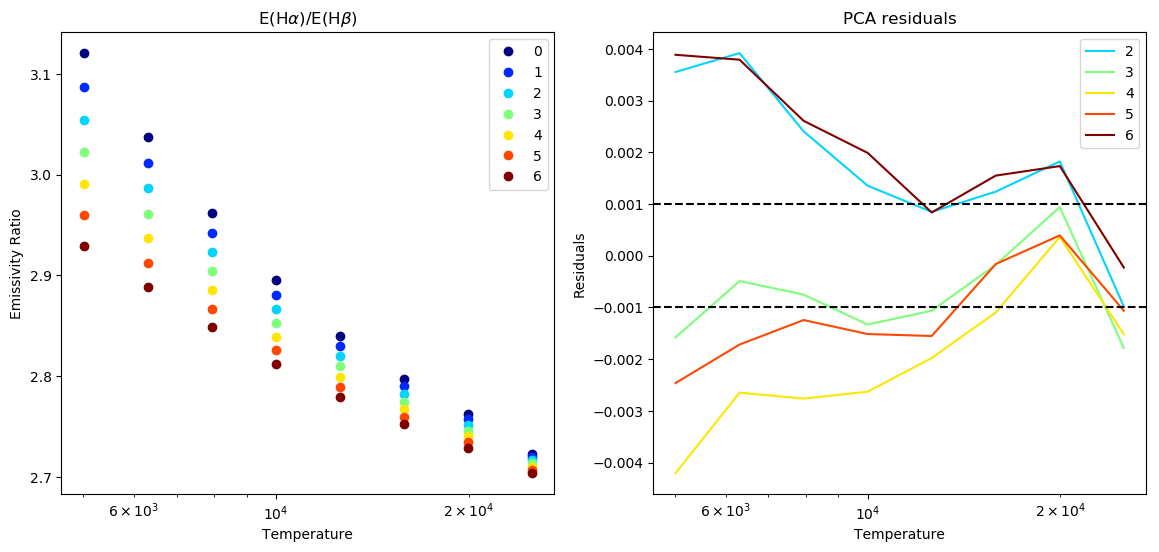

In [110]:
# Open .pdf to save emissivity and residual plots in
ha_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/halpha.pdf')

ha_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 7))))

color = cm.jet(np.linspace(0,1,7))

for i in range(len(extrap_ne_array)):
    if i < 2:
        ax1.plot(temps, ha_extfit.T[i]/hb_extfit.T[i], label=extrap_ne_array[i], marker='o', linestyle='None', color=color[i])

    elif i >= 2:
        ax1.plot(temps, ha_extfit.T[i]/hb_extfit.T[i], label=extrap_ne_array[i], marker='o', linestyle='None', color=color[i])
        ss2015_ha = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], \
                np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[i-2]))))]
        ss2015_hb = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], \
                np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[i-2]))))]
        ax2.plot(temps, ((ha_extfit.T[i]/hb_extfit.T[i])-(ss2015_ha/ss2015_hb))/(ss2015_ha/ss2015_hb), label=extrap_ne_array[i], color=color[i])

ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(H$\alpha$)/E(H$\beta$)')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('PCA residuals')
ax2.legend()

plt.show()
#ha_pdf.savefig(ha_f)
#ha_pdf.close()

### H-gamma

In [ ]:
# Open .pdf to save emissivity and residual plots in
hg_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/hgamma.pdf')

hg_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

#colormap = plt.cm.gist_ncar
#plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 7))))

color = cm.jet(np.linspace(0,1,7))

for i in range(len(extrap_ne_array)):
    if i < 2:
        ax1.plot(temps, hg_extfit.T[i]/hb_extfit.T[i], label=extrap_ne_array[i], marker='o', linestyle='None', color=color[i])

    elif i >= 2:
        ax1.plot(temps, hg_extfit.T[i]/hb_extfit.T[i], label=extrap_ne_array[i], marker='o', linestyle='None', color=color[i])
        ss2015_hg = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 5)[0], \
                np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[i-2]))))]
        ss2015_hb = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], \
                np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[i-2]))))]
        ax2.plot(temps, ((hg_extfit.T[i]/hb_extfit.T[i])-(ss2015_hg/ss2015_hb))/(ss2015_hg/ss2015_hb), label=extrap_ne_array[i], color=color[i])

ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(H$\gamma$)/E(H$\beta$)')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('PCA residuals')
ax2.legend()

plt.show()
hg_pdf.savefig(hg_f)
hg_pdf.close()

### H-delta

In [ ]:
# Open .pdf to save emissivity and residual plots in
hd_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/hdelta.pdf')

hd_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

#colormap = plt.cm.gist_ncar
#plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 7))))

color = cm.jet(np.linspace(0,1,7))

for i in range(len(extrap_ne_array)):
    if i < 2:
        ax1.plot(temps, hd_extfit.T[i]/hb_extfit.T[i], label=extrap_ne_array[i], marker='o', linestyle='None', color=color[i])

    elif i >= 2:
        ax1.plot(temps, hd_extfit.T[i]/hb_extfit.T[i], label=extrap_ne_array[i], marker='o', linestyle='None', color=color[i])
        ss2015_hd = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 6)[0], \
                np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[i-2]))))]
        ss2015_hb = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], \
                np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[i-2]))))]
        ax2.plot(temps, ((hd_extfit.T[i]/hb_extfit.T[i])-(ss2015_hd/ss2015_hb))/(ss2015_hd/ss2015_hb), label=extrap_ne_array[i], color=color[i])

ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(H$\delta$)/E(H$\beta$)')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('PCA residuals')
ax2.legend()

plt.show()
hd_pdf.savefig(hd_f)
hd_pdf.close()

### H8

In [ ]:
# Open .pdf to save emissivity and residual plots in
h8_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/h8_2221.pdf')

h8_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

#colormap = plt.cm.gist_ncar
#plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 7))))

color = cm.jet(np.linspace(0,1,7))

for i in range(len(extrap_ne_array)):
    if i < 2:
        ax1.plot(temps, h8_extfit.T[i]/hb_extfit.T[i], label=extrap_ne_array[i], marker='o', linestyle='None', color=color[i])

    elif i >= 2:
        ax1.plot(temps, h8_extfit.T[i]/hb_extfit.T[i], label=extrap_ne_array[i], marker='o', linestyle='None', color=color[i])
        ss2015_h8 = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 8)[0], \
                np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[i-2]))))]
        ss2015_hb = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], \
                np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[i-2]))))]
        ax1.plot(temps, (ss2015_h8/ss2015_hb), color=color[i], marker='^', markersize=4, label='_nolegend_')
        ax2.plot(temps, ((h8_extfit.T[i]/hb_extfit.T[i])-(ss2015_h8/ss2015_hb))/(ss2015_h8/ss2015_hb), label=extrap_ne_array[i], color=color[i])

ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(H8)/E(H$\beta$) -- 2221')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('PCA residuals')
ax2.legend()

plt.show()
h8_pdf.savefig(h8_f)
h8_pdf.close()

### Pa-gamma

In [ ]:
# Open .pdf to save emissivity and residual plots in
pg_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/pagamma.pdf')

pg_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

#colormap = plt.cm.gist_ncar
#plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 7))))

color = cm.jet(np.linspace(0,1,7))

for i in range(len(extrap_ne_array)):
    if i < 2:
        ax1.plot(temps, pg_extfit.T[i]/hb_extfit.T[i], label=extrap_ne_array[i], marker='o', linestyle='None', color=color[i])

    elif i >= 2:
        ax1.plot(temps, pg_extfit.T[i]/hb_extfit.T[i], label=extrap_ne_array[i], marker='o', linestyle='None', color=color[i])
        ss2015_pg = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 6)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 3)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[i-2]))))]
        ss2015_hb = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], \
                np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[i-2]))))]
        ax2.plot(temps, ((pg_extfit.T[i]/hb_extfit.T[i])-(ss2015_pg/ss2015_hb))/(ss2015_pg/ss2015_hb), label=extrap_ne_array[i], color=color[i])

ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(Pa$\gamma$)/E(H$\beta$)')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('PCA residuals')
ax2.legend()

plt.show()
pg_pdf.savefig(pg_f)
pg_pdf.close()

## Compare PCA emissivities with S&S 2015 (no extrap)

In [138]:
# Open .pdf to save emissivity and residual plots in
ha_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/halpha_curvefits_residuals.pdf')
hg_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/hgamma_curvefits_residuals.pdf')
hd_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/hdelta_curvefits_residuals.pdf')
h8_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/h8_curvefits_residuals.pdf')
pg_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/pg_curvefits_residuals.pdf')

for i in range(2,7):#len(extrap_ne_array)):
    # Need i-2 here in the indices because i starts at 2 when I loop in 'range(2,4)' (this corresponds to n_e = 100 in extrap_ne_array)
    # but I need to index the 0th element in ne_array, which contains no extrapolated densities
    ss2015_ha = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], \
                np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[i-2]))))]
    ss2015_hb = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], \
                np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[i-2]))))]
    ss2015_hg = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 5)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[i-2]))))]
    ss2015_hd = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 6)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[i-2]))))]
    ss2015_h8 = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 8)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[i-2]))))]
    ss2015_pg = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 6)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 3)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(ne_array[i-2]))))]

    old_ha_dens = mfr.hydrogen_emissivity_old(6563, temps, ne_array[i-2]) * (1 + mfr.hydrogen_collision_to_recomb(1e-4, 6563, temps)) / (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4861, temps))
    old_hb_dens = mfr.hydrogen_emissivity_old(4861, temps, ne_array[i-2])
    old_hg_dens = mfr.hydrogen_emissivity_old(4341, temps, ne_array[i-2]) * (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4341, temps)) / (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4861, temps))
    old_hd_dens = mfr.hydrogen_emissivity_old(4102, temps, ne_array[i-2]) * (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4102, temps)) / (1 + mfr.hydrogen_collision_to_recomb(1e-4, 4861, temps))
    
    # Plot
    # H-alpha
    ha_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(temps, functional_form(temps, ha_a_coeff[i-2], ha_b_coeff[i-2], ha_c_coeff[i-2], ha_d_coeff[i-2])/functional_form(temps, hb_a_coeff[i-2], hb_b_coeff[i-2], hb_c_coeff[i-2], hb_d_coeff[i-2]), label='scipy curvefit', color='magenta')
    ax1.plot(temps, ss2015_ha/ss2015_hb, label='S\&S 2015', color='blue', marker='^', markersize=6, linestyle='None')
    ax1.plot(temps, ha_extfit.T[i]/hb_extfit.T[i], label='PCA', color='green', marker='*', markersize=6, linestyle='None')
    ax1.plot(temps, old_ha_dens, 'o', label='H-alpha, H\&S 1987', color='red')
    ax1.set_xscale('log')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Emissivity Ratio')
    ax1.set_title(r'E(H$\alpha$)/E(H$\beta), n_{e}=$'+str(ne_array[i-2]))
    ax1.legend()
    ax2.plot(temps, ((functional_form(temps, ha_a_coeff[i-2], ha_b_coeff[i-2], ha_c_coeff[i-2], ha_d_coeff[i-2])/functional_form(temps, hb_a_coeff[i-2], hb_b_coeff[i-2], hb_c_coeff[i-2], hb_d_coeff[i-2])-(ss2015_ha/ss2015_hb))/(ss2015_ha/ss2015_hb)), label='scipy curvefit', color='magenta')
    ax2.plot(temps, ((ha_extfit.T[i]/hb_extfit.T[i])-(ss2015_ha/ss2015_hb))/(ss2015_ha/ss2015_hb), color='green', label='PCA')
    ax2.axhline(0.001, ls='--', color='black')
    ax2.axhline(-0.001, ls='--', color='black')
    ax2.set_xscale('log')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel(r'Residuals')
    ax2.set_title(r'$n_{e}$='+str(ne_array[i-2])+'~$cm^{-3}$')
    ha_pdf.savefig(ha_f)
    
    # H-gamma
    hg_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(temps, functional_form(temps, hg_a_coeff[i-2], hg_b_coeff[i-2], hg_c_coeff[i-2], hg_d_coeff[i-2])/functional_form(temps, hb_a_coeff[i-2], hb_b_coeff[i-2], hb_c_coeff[i-2], hb_d_coeff[i-2]), label='scipy curvefit', color='magenta')
    ax1.plot(temps, ss2015_hg/ss2015_hb, label='S\&S 2015', color='blue', marker='^', markersize=6, linestyle='None')
    ax1.plot(temps, hg_extfit.T[i]/hb_extfit.T[i], label='PCA', color='green', marker='*', markersize=6, linestyle='None')
    ax1.plot(temps, old_hg_dens, 'o', label='H-gamma, H\&S 1987', color='red')
    ax1.set_xscale('log')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Emissivity Ratio')
    ax1.set_title(r'E(H$\gamma$)/E(H$\beta), n_{e}=$'+str(ne_array[i-2]))
    ax1.legend()
    ax2.plot(temps, ((functional_form(temps, hg_a_coeff[i-2], hg_b_coeff[i-2], hg_c_coeff[i-2], hg_d_coeff[i-2])/functional_form(temps, hb_a_coeff[i-2], hb_b_coeff[i-2], hb_c_coeff[i-2], hb_d_coeff[i-2])-(ss2015_hg/ss2015_hb))/(ss2015_hg/ss2015_hb)), label='scipy curvefit', color='magenta')
    ax2.plot(temps, ((hg_extfit.T[i]/hb_extfit.T[i])-(ss2015_hg/ss2015_hb))/(ss2015_hg/ss2015_hb), color='green', label='PCA')
    ax2.axhline(0.001, ls='--', color='black')
    ax2.axhline(-0.001, ls='--', color='black')
    ax2.set_xscale('log')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel(r'Residuals')
    ax2.set_title(r'$n_{e}$='+str(ne_array[i-2])+'~$cm^{-3}$')
    hg_pdf.savefig(hg_f)
    
    # H-delta
    hd_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(temps, functional_form(temps, hd_a_coeff[i-2], hd_b_coeff[i-2], hd_c_coeff[i-2], hd_d_coeff[i-2])/functional_form(temps, hb_a_coeff[i-2], hb_b_coeff[i-2], hb_c_coeff[i-2], hb_d_coeff[i-2]), label='scipy curvefit', color='magenta')
    ax1.plot(temps, ss2015_hd/ss2015_hb, label='S\&S 2015', color='blue', marker='^', markersize=6, linestyle='None')
    ax1.plot(temps, hd_extfit.T[i]/hb_extfit.T[i], label='PCA', color='green', marker='*', markersize=6, linestyle='None')
    ax1.plot(temps, old_hd_dens, 'o', label='H-delta, H\&S 1987', color='red')
    ax1.set_xscale('log')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Emissivity Ratio')
    ax1.set_title(r'E(H$\delta$)/E(H$\beta), n_{e}=$'+str(ne_array[i-2]))
    ax1.legend()
    ax2.plot(temps, ((functional_form(temps, hd_a_coeff[i-2], hd_b_coeff[i-2], hd_c_coeff[i-2], hd_d_coeff[i-2])/functional_form(temps, hb_a_coeff[i-2], hb_b_coeff[i-2], hb_c_coeff[i-2], hb_d_coeff[i-2])-(ss2015_hd/ss2015_hb))/(ss2015_hd/ss2015_hb)), label='scipy curvefit', color='magenta')
    ax2.plot(temps, ((hd_extfit.T[i]/hb_extfit.T[i])-(ss2015_hd/ss2015_hb))/(ss2015_hd/ss2015_hb), color='green', label='PCA')
    ax2.axhline(0.001, ls='--', color='black')
    ax2.axhline(-0.001, ls='--', color='black')
    ax2.set_xscale('log')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel(r'Residuals')
    ax2.set_title(r'$n_{e}$='+str(ne_array[i-2])+'~$cm^{-3}$')
    hd_pdf.savefig(hd_f)

    # H8
    h8_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(temps, functional_form(temps, h8_a_coeff[i-2], h8_b_coeff[i-2], h8_c_coeff[i-2], h8_d_coeff[i-2])/functional_form(temps, hb_a_coeff[i-2], hb_b_coeff[i-2], hb_c_coeff[i-2], hb_d_coeff[i-2]), label='scipy curvefit', color='magenta')
    ax1.plot(temps, ss2015_h8/ss2015_hb, label='S\&S 2015', color='blue', marker='^', markersize=6, linestyle='None')
    ax1.plot(temps, h8_extfit.T[i]/hb_extfit.T[i], label='PCA', color='green', marker='*', markersize=6, linestyle='None')
    ax1.set_xscale('log')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Emissivity Ratio')
    ax1.set_title(r'E(H8)/E(H$\beta), n_{e}=$'+str(ne_array[i-2]))
    ax1.legend()
    ax2.plot(temps, ((functional_form(temps, h8_a_coeff[i-2], h8_b_coeff[i-2], h8_c_coeff[i-2], h8_d_coeff[i-2])/functional_form(temps, hb_a_coeff[i-2], hb_b_coeff[i-2], hb_c_coeff[i-2], hb_d_coeff[i-2])-(ss2015_h8/ss2015_hb))/(ss2015_h8/ss2015_hb)), label='scipy curvefit', color='magenta')
    ax2.plot(temps, ((h8_extfit.T[i]/hb_extfit.T[i])-(ss2015_h8/ss2015_hb))/(ss2015_h8/ss2015_hb), color='green', label='PCA')
    ax2.axhline(0.001, ls='--', color='black')
    ax2.axhline(-0.001, ls='--', color='black')
    ax2.set_xscale('log')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel(r'Residuals')
    ax2.set_title(r'$n_{e}$='+str(ne_array[i-2])+'~$cm^{-3}$')
    h8_pdf.savefig(h8_f)
    
    # Pa-gamma
    pg_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(temps, functional_form(temps, pg_a_coeff[i-2], pg_b_coeff[i-2], pg_c_coeff[i-2], pg_d_coeff[i-2])/functional_form(temps, hb_a_coeff[i-2], hb_b_coeff[i-2], hb_c_coeff[i-2], hb_d_coeff[i-2]), label='scipy curvefit', color='magenta')
    ax1.plot(temps, ss2015_pg/ss2015_hb, label='S\&S 2015', color='blue', marker='^', markersize=6, linestyle='None')
    ax1.plot(temps, pg_extfit.T[i]/hb_extfit.T[i], label='PCA', color='green', marker='*', markersize=6, linestyle='None')
    ax1.set_xscale('log')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Emissivity Ratio')
    ax1.set_title(r'E(Pa$\gamma$)/E(H$\beta), n_{e}=$'+str(ne_array[i-2]))
    ax1.legend()
    ax2.plot(temps, ((functional_form(temps, pg_a_coeff[i-2], pg_b_coeff[i-2], pg_c_coeff[i-2], pg_d_coeff[i-2])/functional_form(temps, hb_a_coeff[i-2], hb_b_coeff[i-2], hb_c_coeff[i-2], hb_d_coeff[i-2])-(ss2015_pg/ss2015_hb))/(ss2015_pg/ss2015_hb)), label='scipy curvefit', color='magenta')
    ax2.plot(temps, ((pg_extfit.T[i]/hb_extfit.T[i])-(ss2015_pg/ss2015_hb))/(ss2015_pg/ss2015_hb), color='green', label='PCA')
    ax2.axhline(0.001, ls='--', color='black')
    ax2.axhline(-0.001, ls='--', color='black')
    ax2.set_xscale('log')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel(r'Residuals')
    ax2.set_title(r'$n_{e}$='+str(ne_array[i-2])+'~$cm^{-3}$')
    pg_pdf.savefig(pg_f)
    
# Close pdfs
ha_pdf.close()
hg_pdf.close()
hd_pdf.close()
h8_pdf.close()
pg_pdf.close()

UnboundLocalError: local variable 'line' referenced before assignment